In [1]:
!pwd
%cd /media/laptq/data/workspace/hello-gen-ai

/media/laptq/data/workspace/hello-gen-ai/notebooks
/media/laptq/data/workspace/hello-gen-ai


/media/laptq/data/workspace/hello-gen-ai/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
BATCHSIZE = 128
STEP_SIZE = 200
LR = 0.001
EPOCHS = 15
DEVICE = 'cuda:0'
N_HIDDENS = 8
N_LABELS = 10

Some [GAN hacks](https://github.com/soumith/ganhacks):

1. Input should be normalized to [-1, 1]

In [31]:
device = torch.device(DEVICE)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),   # GAN hack
    ]
)

trainset = torchvision.datasets.MNIST(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)
trainloader = DataLoader(
    trainset, 
    batch_size=BATCHSIZE,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.MNIST(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)
testloader = DataLoader(
    testset, 
    batch_size=BATCHSIZE,
    shuffle=False, 
    num_workers=2
)

classes = [str(i) for i in range(10)]


# print image shape
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, torch.min(images), torch.max(images), torch.mean(images), torch.std(images))

torch.Size([128, 1, 28, 28]) tensor(-1.) tensor(1.) tensor(-0.7437) tensor(0.6115)


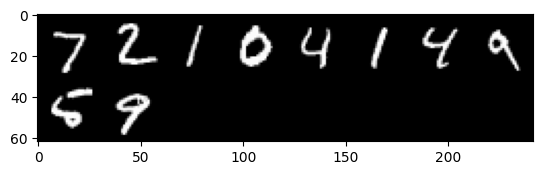

7     2     1     0     4     1     4     9     5     9    


In [5]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter)

n_show = 10
imshow(torchvision.utils.make_grid(images[:n_show]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(min(n_show, BATCHSIZE))))

## GAN

In [35]:
class Discriminator(nn.Module):
    
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)    # signmoid later


    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.leaky_relu(self.fc1(x), 0.2)  # GAN hack
        x = F.leaky_relu(self.fc2(x), 0.2)  # GAN hack
        x = self.fc3(x)

        return x


class Generator(nn.Module):

    def __init__(self, **kwargs):
        super(Generator, self).__init__()

        n_hiddens = kwargs['n_hiddens']

        self.fc1 = nn.Linear(n_hiddens, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 28*28)

    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)  # GAN hack
        x = F.dropout(x, 0.3)   # GAN hack
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = torch.tanh(self.fc4(x))

        x = torch.reshape(x, (-1, 1, 28, 28))

        return x
    

net_disc = Discriminator()
net_gen = Generator(n_hiddens=N_HIDDENS)

net_disc.to(device)
net_gen.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_disc = optim.Adam(
    net_disc.parameters(),
    lr=LR,
)
optimizer_gen = optim.Adam(
    net_gen.parameters(),
    lr=LR,
)

net_disc(torch.randn(1, 1, 28, 28).to(device))
net_gen(torch.randn(1, N_HIDDENS).to(device))

net_disc, net_gen

(Discriminator(
   (fc1): Linear(in_features=784, out_features=512, bias=True)
   (fc2): Linear(in_features=512, out_features=256, bias=True)
   (fc3): Linear(in_features=256, out_features=1, bias=True)
 ),
 Generator(
   (fc1): Linear(in_features=8, out_features=256, bias=True)
   (fc2): Linear(in_features=256, out_features=512, bias=True)
   (fc3): Linear(in_features=512, out_features=1024, bias=True)
   (fc4): Linear(in_features=1024, out_features=784, bias=True)
 ))

## References

1. https://freedium.cfd/https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f
2. https://github.com/soumith/ganhacks